In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pickle
import matplotlib.ticker as mtick
import math
from itertools import combinations
import random
from sklearn.linear_model import LinearRegression
from qgrid import show_grid
from adjustText import adjust_text
# from crispy.Utils import Utils

In [2]:
plt.rcParams['font.family'] = 'Arial'
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['font.size'] = 18
# plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.set_palette("Dark2")
plt.rcParams['figure.dpi'] = 200


# from crispy.CrispyPlot import CrispyPlot

sns.set(style="ticks", context="paper", font_scale=1, font="Arial")
sns.set_context("paper",
                rc={
                    "axes.linewidth": 0.5,
                    'xtick.major.size': 2,
                    'xtick.major.width': 0.25,
                    'ytick.major.size': 2,
                    'ytick.major.width': 0.25,
                    'xtick.labelsize': 6,
                    'ytick.labelsize': 6,
                    'axes.labelsize': 7
                })

In [3]:
seed = 42

In [4]:
name_map_df = pd.read_csv(f"../../data/misc/uniprot_human_idmap.tab.gz",
                       sep='\t')
name_map_dict = name_map_df.set_index("Entry name").to_dict()['Gene names  (primary )']
protein2rna_map = name_map_dict
rna2protein_map = name_map_df.set_index("Gene names  (primary )").to_dict()['Entry name']

# load data

In [8]:
drug_df = pd.read_csv("../../data/drug/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [9]:
colour_list = pd.read_csv('../../data/colour_list.txt',header=None)[0].tolist()

In [10]:
meta_sample = pd.read_csv("../../data/protein/e0022_diann_051021_sample_mapping_replicates.txt", sep='\t')
meta_sample = meta_sample[~meta_sample['Cell_line'].str.contains('Control')].reset_index(drop=True)
meta = meta_sample.drop_duplicates(['Cell_line']).reset_index(drop=True)

In [12]:
protein_working = pd.read_csv(
    "../../data/protein/e0022_diann_051021_working_matrix_averaged.txt",
    sep='\t')
protein_working = protein_working.rename(columns={'Project_Identifier':'Cell_line'})
protein_working['Cell_line'] = protein_working['Cell_line'].map(lambda x:x.split(';')[1])
protein_working = protein_working.set_index('Cell_line')
protein_working = protein_working[[x for x in protein_working.columns if ';' in x]]
protein_working.columns = [x.split(';')[1] for x in protein_working.columns]
# protein_working = protein_working[protein_working.index.isin(meta['Cell_line'])]

In [13]:
protein_frozen = pd.read_csv(
    "../../data/protein/e0022_diann_051021_frozen_matrix_averaged.txt",
    sep='\t')
protein_frozen = protein_frozen.rename(columns={'Project_Identifier':'Cell_line'})
protein_frozen['Cell_line'] = protein_frozen['Cell_line'].map(lambda x:x.split(';')[1])
protein_frozen = protein_frozen.set_index('Cell_line')
protein_frozen = protein_frozen[[x for x in protein_frozen.columns if ';' in x]]
protein_frozen.columns = [x.split(';')[1] for x in protein_frozen.columns]
# protein_frozen = protein_frozen[protein_frozen.index.isin(meta['Cell_line'])]

In [14]:
cell_lines_no_blood = meta[
    meta['Tissue_type'] != 'Haematopoietic and Lymphoid']['Cell_line'].unique()

In [15]:
cell_lines_lung = meta[meta['Cancer_type'].isin(
    ['Non-Small Cell Lung Carcinoma',
     'Small Cell Lung Carcinoma'])]['Cell_line'].unique()
cell_lines_breast = meta[meta['Tissue_type'] == 'Breast']['Cell_line'].unique()

In [16]:
tissue_type_map = meta.set_index('Cell_line')[['Tissue_type']].to_dict()['Tissue_type']
cancer_type_map = meta.set_index('Cell_line')[['Cancer_type']].to_dict()['Cancer_type']
batch_map = meta.set_index('Cell_line')[['Batch']].to_dict()['Batch']
instrument_map = meta.set_index('Cell_line')[['Instrument']].to_dict()['Instrument']
cancer_subtype_map = meta.set_index('Cell_line')[['Cancer_subtype']].to_dict()['Cancer_subtype']


In [17]:
cancer_colours = {
    'Non-Small Cell Lung Carcinoma': '#007fff',
    'Prostate Carcinoma': '#665d1e',
    'Gastric Carcinoma': '#ffbf00',
    'Glioblastoma': '#fbceb1',
    'Melanoma': '#ff033e',
    'Bladder Carcinoma': '#ab274f',
    'B-Lymphoblastic Leukemia': '#d5e6f7',
    'Kidney Carcinoma': '#7cb9e8',
    'Thyroid Gland Carcinoma': '#efdecd',
    'Rhabdomyosarcoma': '#8db600',
    'Head and Neck Carcinoma': '#e9d66b',
    'Ovarian Carcinoma': '#b284be',
    "B-Cell Non-Hodgkin's Lymphoma": '#b2beb5',
    'Other Solid Carcinomas': '#10b36f',
    "Ewing's Sarcoma": '#6e7f80',
    'T-Lymphoblastic Leukemia': '#ff7e00',
    'Plasma Cell Myeloma': '#87a96b',
    'Endometrial Carcinoma': '#c9ffe5',
    'Non-Cancerous': '#9f2b68',
    'Breast Carcinoma': '#00ffff',
    'Pancreatic Carcinoma': '#008000',
    'Neuroblastoma': '#cd9575',
    "Burkitt's Lymphoma": '#72a0c1',
    'Hairy Cell Leukemia': '#a32638',
    'Chronic Myelogenous Leukemia': '#9966cc',
    'Glioma': '#f19cbb',
    'Cervical Carcinoma': '#e32636',
    'Colorectal Carcinoma': '#3b7a57',
    'Hepatocellular Carcinoma': '#faebd7',
    'Vulvar carcinoma': '#fdee00',
    'Osteosarcoma': '#00308f',
    'Chondrosarcoma': '#7fffd4',
    'Small Cell Lung Carcinoma': '#c46210',
    'Esophageal Carcinoma': '#a8bb19',
    'Uncertain': '#ff9966',
    "T-Cell Non-Hodgkin's Lymphoma": '#a52a2a',
    'Non-small Cell Lung Carcinoma': '#568203',
    'Other Sarcomas': '#4b5320',
    'Biliary Tract Carcinoma': '#5d8aa8',
    'Acute Myeloid Leukemia': '#8f9779',
    "Hodgkin's Lymphoma": '#915c83',
    'Mesothelioma': '#841b2d',
    'B-Lymphoblastic leukemia': '#a4c639',
    'Other Blood Cancers': '#3b444b',
    'Carcinoid Tumour': '#006600',
    'Leiomyosarcoma': '#0000ff',
    "T-cell Non-Hodgkin's Lymphoma": '#666699',
    'T-Lymphoblastic Lymphoma': '#996666'
}

tissue_colours = {
    'Lung': '#007fff',
    'Prostate': '#665d1e',
    'Stomach': '#ffbf00',
    'Central Nervous System': '#fbceb1',
    'Skin': '#ff033e',
    'Bladder': '#ab274f',
    'Haematopoietic and Lymphoid': '#d5e6f7',
    'Kidney': '#7cb9e8',
    'Thyroid': '#efdecd',
    'Soft Tissue': '#8db600',
    'Head and Neck': '#e9d66b',
    'Ovary': '#b284be',
    'Bone': '#b2beb5',
    'Endometrium': '#10b36f',
    'Breast': '#6e7f80',
    'Pancreas': '#ff7e00',
    'Peripheral Nervous System': '#87a96b',
    'Cervix': '#c9ffe5',
    'Large Intestine': '#9f2b68',
    'Liver': '#00ffff',
    'Vulva': '#008000',
    'Esophagus': '#cd9575',
    'Biliary Tract': '#72a0c1',
    'Other tissue': '#a32638',
    'Small Intestine': '#9966cc',
    'Placenta': '#f19cbb',
    'Testis': '#e32636',
    'Adrenal Gland': '#3b7a57'
}

instrument_colours = {
    'M01': '#66c2a5',
    'M02': '#fc8d62',
    'M03': '#8da0cb',
    'M04': '#e78ac3',
    'M05': '#a6d854',
    'M06': '#ffd92f'
}

batch_colours = {
    'P02': '#beaed4',
    'P03': '#fdc086',
    'P04': '#386cb0',
    'P05': '#f0027f',
    'P06': '#bf5b17'
}

tissue_colours['Other'] = 'white'
cancer_colours['Other'] = 'white'

In [18]:
meta_cell_lines = meta.drop_duplicates('Cell_line')

In [19]:
meta_cell_lines[['Cell_line', 'Tissue_type', 'Cancer_type']].dropna().shape

(949, 3)

In [20]:
drug = pd.read_csv("../../data/drug/drug_info.csv")

In [21]:
drug_colours = dict(
    zip(drug['target_pathway'].unique(),
        colour_list[:drug['target_pathway'].unique().size]))

# Overview

## cell line

In [29]:
protein_freq = (protein_frozen.shape[0] -
                protein_frozen.isna().sum(axis=0)) / protein_frozen.shape[0]

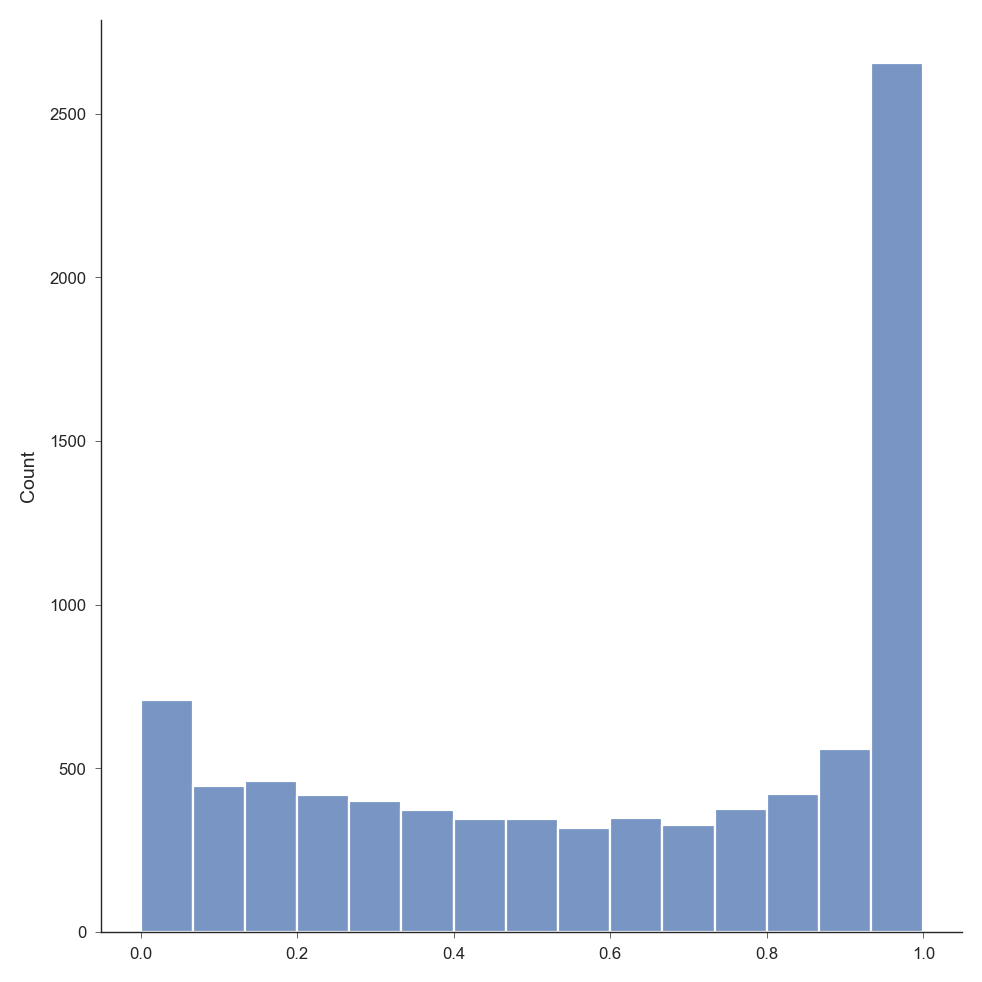

In [30]:
sns.displot(protein_freq)

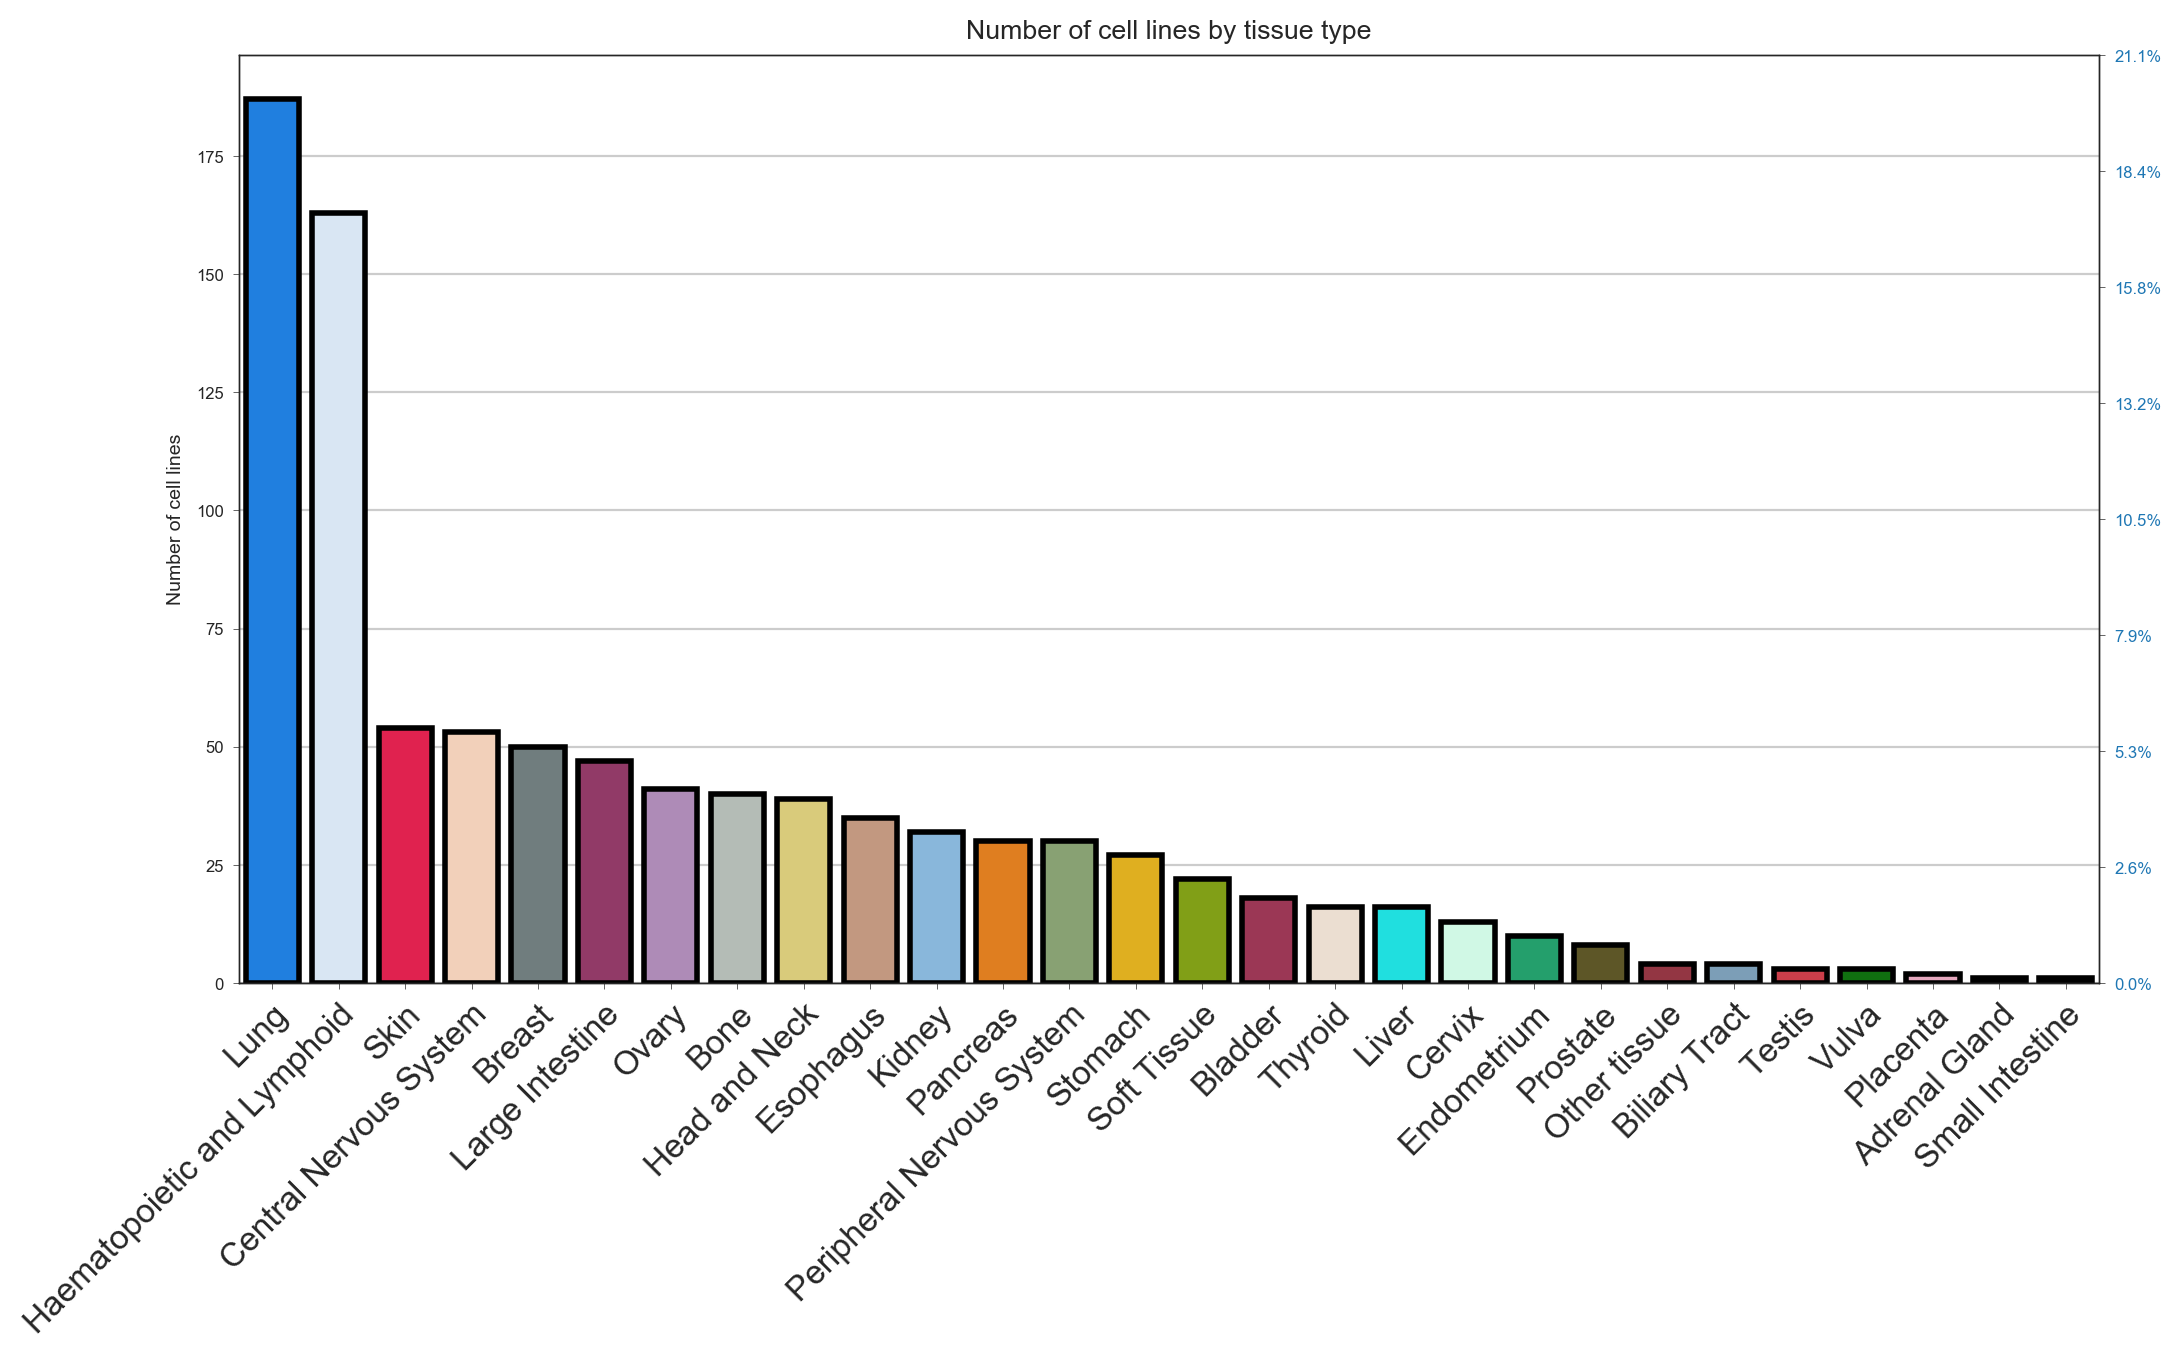

In [31]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.grid()
sns.countplot(x='Tissue_type',
              data=meta_cell_lines,
              hue_order=list(tissue_colours.keys()),
              order=meta_cell_lines['Tissue_type'].value_counts().index,
              palette=tissue_colours,
              linewidth=2,
              edgecolor="black",
              ax=ax1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('',
               color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, ax1.get_ylim()[1] * 100 / meta_cell_lines.shape[0])
ax2.set_yticks([x / meta_cell_lines.shape[0] * 100 for x in range(0, 201, 25)])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.setp(ax1.get_xticklabels(),
         rotation=45,
         ha="right",
         size=12,
         rotation_mode="anchor")
ax1.set_ylabel("Number of cell lines")
ax1.set_xlabel("")
ax1.set_title("Number of cell lines by tissue type")
plt.gcf().subplots_adjust(bottom=0.3)
# plt.savefig("../../plots/landscape/cell_line_by_tissue.pdf", dpi=500)

NameError: name 'meta_cell_lines' is not defined

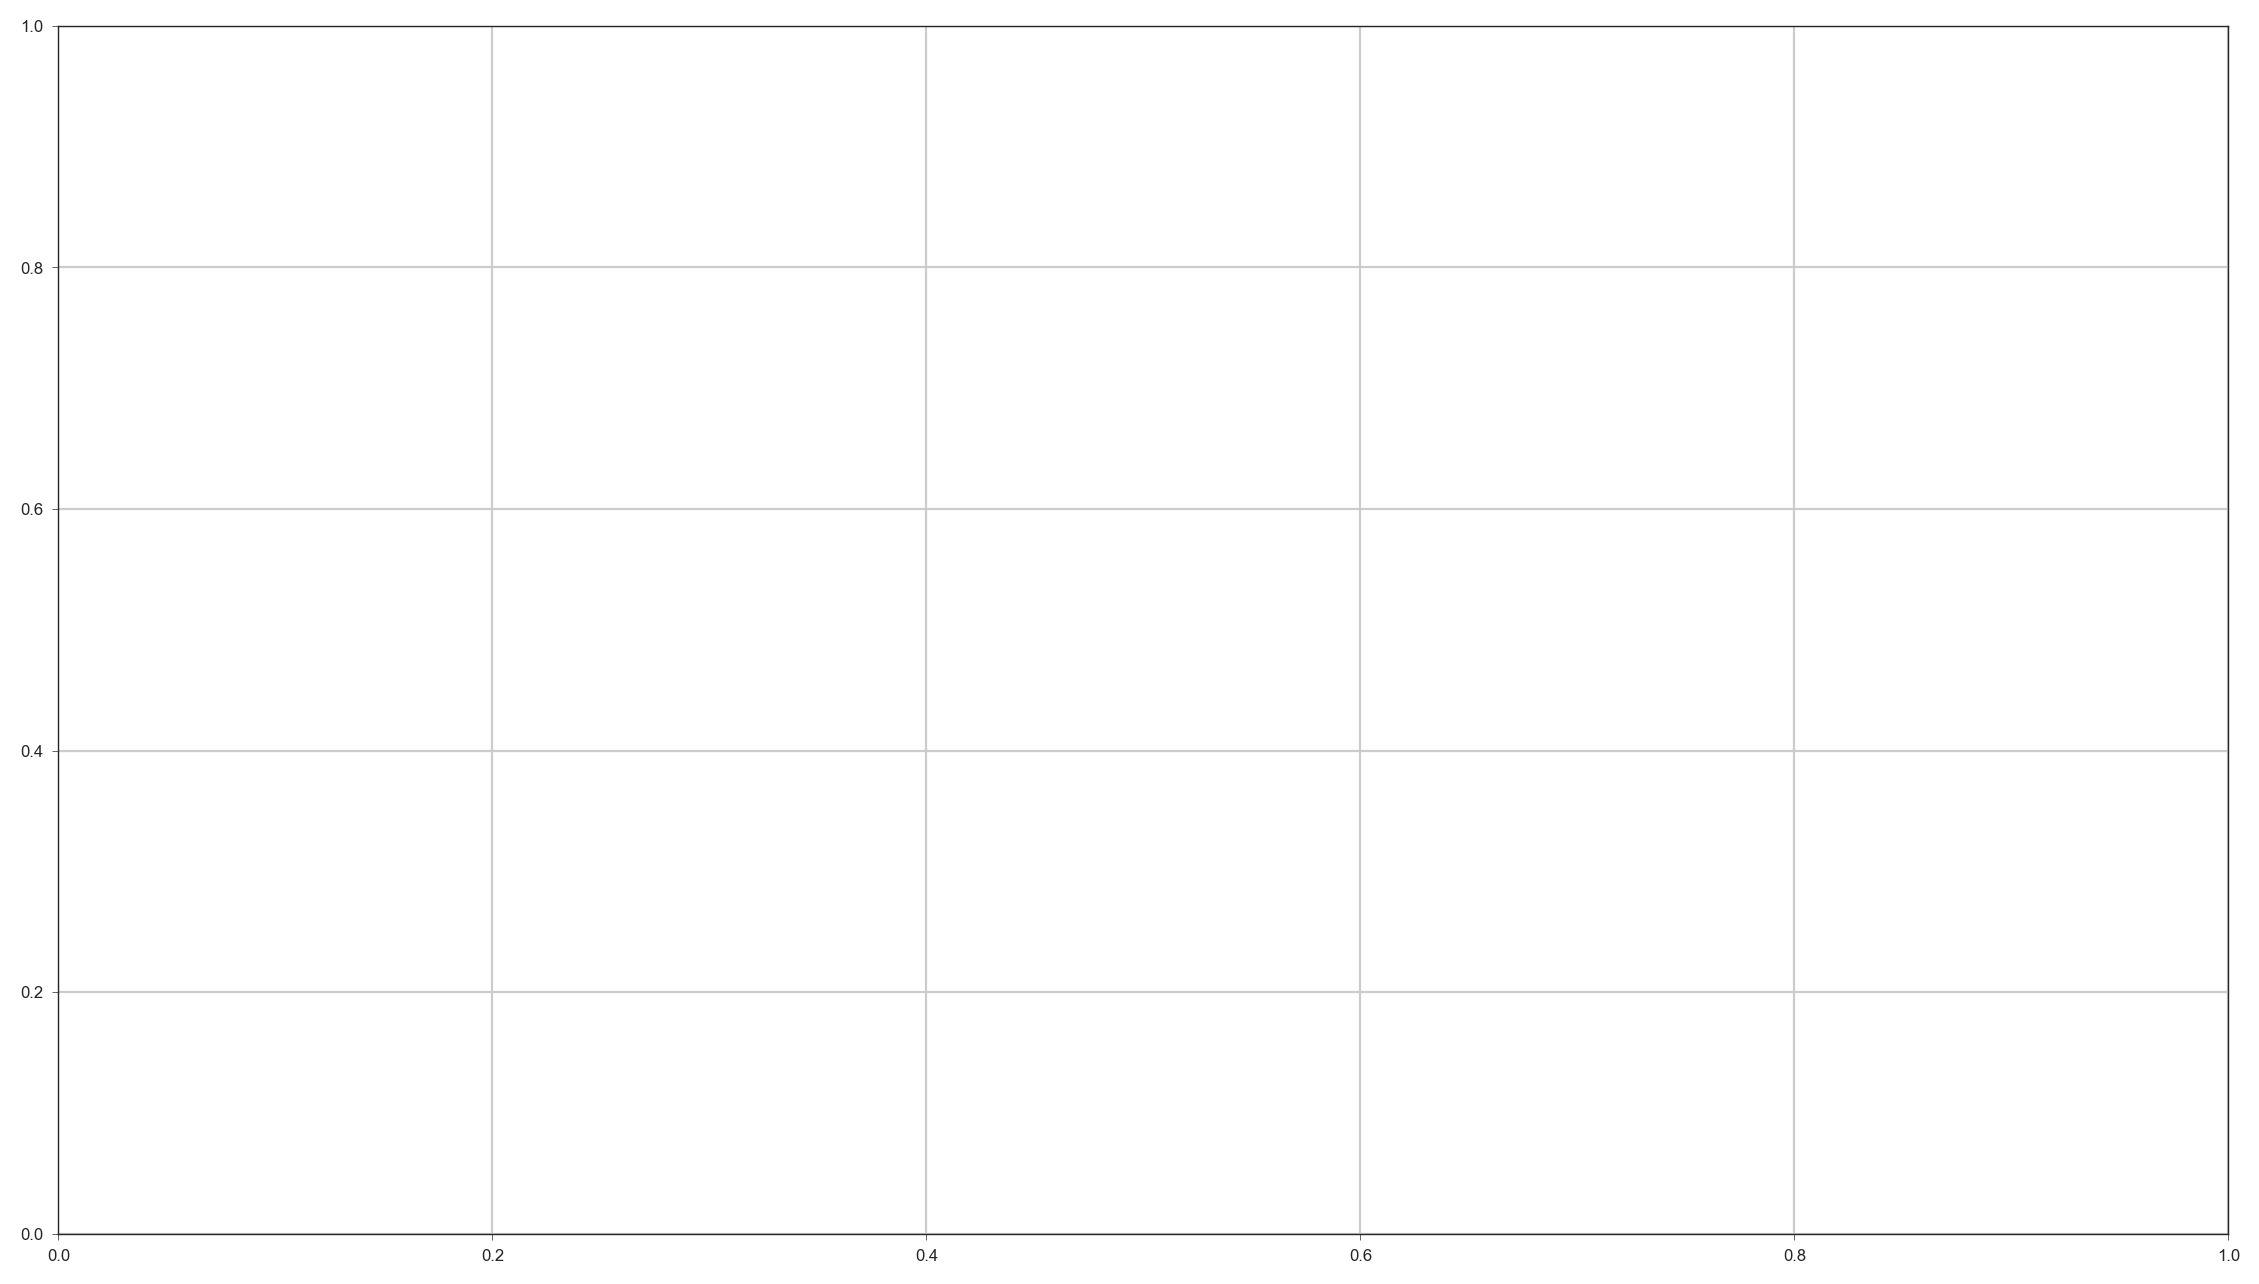

In [14]:
fig, ax1 = plt.subplots(figsize=(14, 8))
plt.grid()
sns.countplot(x='Cancer_type',
              data=meta_cell_lines,
              hue_order=list(cancer_colours.keys()),
              order=meta_cell_lines['Cancer_type'].value_counts().index,
              palette=cancer_colours,
              linewidth=2,
              edgecolor="black",
              ax=ax1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('',
               color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, ax1.get_ylim()[1] * 100 / meta_cell_lines.shape[0])
ax2.set_yticks([x / meta_cell_lines.shape[0] * 100 for x in range(0, 81, 20)])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.setp(ax1.get_xticklabels(),
         rotation=45,
         size=12,
         ha="right",
         rotation_mode="anchor")
ax1.set_ylabel("Number of cell lines")
ax1.set_xlabel("")
ax1.set_title("Number of cell lines by cancer type")
plt.gcf().subplots_adjust(bottom=0.3)
# plt.savefig("../../plots/landscape/cell_line_by_cancer.pdf", dpi=500)

In [ ]:
qgrid.show_grid(meta_cell_lines[['Cancer_type','Tissue_type']].drop_duplicates())

## protein

In [22]:
protein_working_protein_count = pd.DataFrame(
    protein_working.shape[1] - protein_working.isnull().sum(axis=1).sort_values(),
    columns=['Number of proteins']).reset_index()

In [26]:
protein_working_protein_count['Tissue'] = protein_working_protein_count['Cell_line'].map(tissue_type_map)

In [112]:
protein_frozen_cellline_count = pd.DataFrame(
    protein_frozen.shape[0] - protein_frozen.isnull().sum(axis=0).sort_values(),
    columns=['Number of cell lines']).reset_index()

protein_frozen_cellline_count = protein_frozen_cellline_count.groupby(
    'Number of cell lines').size().reset_index(name='count')

protein_frozen_cellline_count['Number of proteins'] = protein_frozen_cellline_count[
    'count'].iloc[::-1].cumsum()

In [113]:
protein_frozen_cellline_count = protein_frozen_cellline_count.drop('count', axis=1)

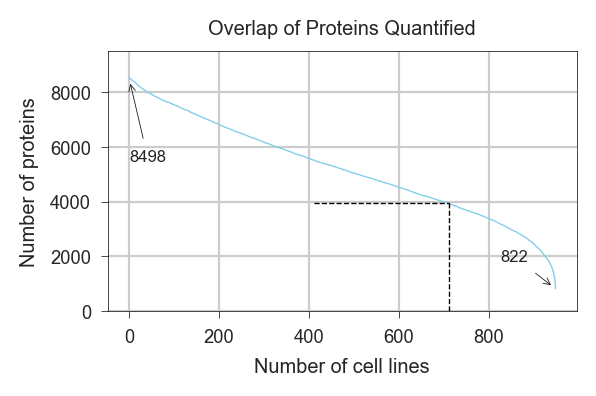

In [135]:
fig, ax = plt.subplots(figsize=(3, 2))
plt.grid()
ax = sns.lineplot(x='Number of cell lines',
                  y='Number of proteins',
                  color='skyblue',
                  linewidth=0.5,
                  data=protein_frozen_cellline_count)

ax.annotate(protein_frozen_cellline_count['Number of proteins'].max(),
            xy=(0, protein_frozen.shape[1]),
            xycoords='data',
            xytext=(0, -30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", lw=0.3, color="k"),
            fontsize=6)
ax.annotate(protein_frozen_cellline_count['Number of proteins'].min(),
            xy=(protein_frozen.shape[0],
                protein_frozen_cellline_count['Number of proteins'].min()),
            xycoords='data',
            xytext=(-20, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", lw=0.3, color="k"),
            fontsize=6)
# missing_ratio = np.sum(np.isnan(protein_frozen.values.flatten())) / (
#     protein_frozen.shape[0] * protein_frozen.shape[1])
# ax.text(0.1,
#         0.1,
#         f"Missing percentage: {missing_ratio*100:.2f}%",
#         transform=ax.transAxes)

celllines75 = protein_frozen_cellline_count.iloc[-1, 0] * 0.75
protein75 = protein_frozen_cellline_count[
    protein_frozen_cellline_count['Number of cell lines'] ==
    int(celllines75)+1].iloc[0,1]


ax.plot((celllines75-300, celllines75), (protein75,protein75), c='black', ls='--', lw=0.5)
ax.plot((celllines75, celllines75), (0,protein75), c='black', ls='--', lw=0.5)

plt.ylim(0, 9500)
plt.title("Overlap of Proteins Quantified")
plt.tight_layout()
# plt.savefig("../../plots/landscape/fraction_of_celllines.pdf", dpi=500)
plt.savefig("../../plots/final_supp_plots/SuppFig1F.pdf", dpi=500)

In [136]:
protein_frozen_cellline_count['percentage'] = protein_frozen_cellline_count[
    'Number of cell lines'] / protein_frozen.shape[0]

In [27]:
protein_frozen_cellline_count.to_csv("../../plots/plot_data/SuppFig1A_protein_overlap.csv", index=False)

In [28]:
protein_frozen_cellline_count = pd.read_csv("../../plots/plot_data/SuppFig1A_protein_overlap.csv")

In [138]:
protein_frozen_cellline_count[protein_frozen_cellline_count['Number of cell lines']==int(celllines75)+1]

,Number of cell lines,Number of proteins,percentage
706,712,3931,0.750263


# Dimensionality Reduction

In [22]:
pca = PCA(n_components=50, random_state=seed)
reducer = umap.UMAP(random_state=seed)

pca_prot = pca.fit_transform(protein_working.fillna(-2.743351))

embedding_prot = reducer.fit_transform(pca_prot)

df_umap = pd.DataFrame({
    'UMAP_1': embedding_prot[:, 0],
    'UMAP_2': embedding_prot[:, 1]
}, index=protein_working.index)

df_umap['Tissue'] = df_umap.index.map(tissue_type_map)
df_umap['Cancer'] = df_umap.index.map(cancer_type_map)
df_umap['Batch'] = df_umap.index.map(batch_map)
df_umap['Instrument'] = df_umap.index.map(instrument_map)

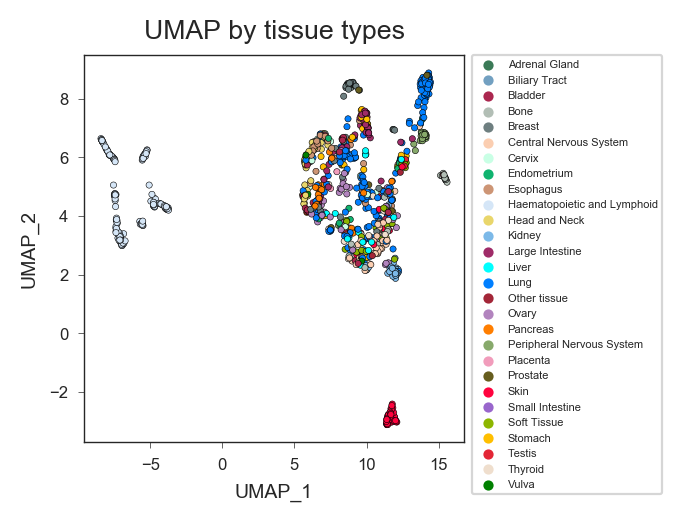

In [50]:
fig = plt.figure(figsize=(3.5, 2.7))
sns.scatterplot(x='UMAP_1',
                y='UMAP_2',
                hue='Tissue',
                hue_order=sorted(list(df_umap['Tissue'].unique())),
                data=df_umap,
                palette=tissue_colours,
                legend='full',
                edgecolor='black',
                s=5,
                linewidth=0.2)
plt.legend(bbox_to_anchor=(1.02, 1),
           loc=2,
           borderaxespad=0.,
           prop={'size': 4},
           markerscale=0.6)
plt.title("UMAP by tissue types")
plt.gcf().subplots_adjust(right=0.7)
plt.tight_layout()

# plt.savefig("../../plots/landscape/umap_pca_umap_all.pdf", dpi=500)

In [51]:
df_umap.to_csv("../../plots/plot_data/Fig1E_UMAP_all_cell_lines.csv")

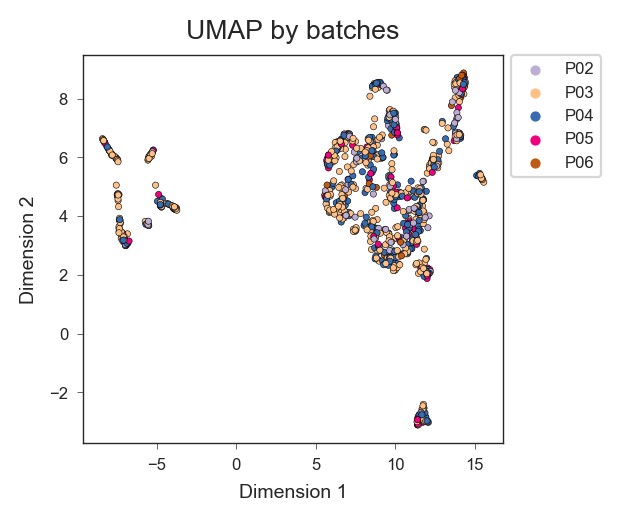

In [35]:
fig = plt.figure(figsize=(3.2, 2.7))
sns.scatterplot(x='UMAP_1',
                y='UMAP_2',
                hue='Batch',
                data=df_umap,
                palette=batch_colours,
                legend='full',
                edgecolor='black',
                hue_order=sorted(batch_colours.keys()),
                s=5,
                linewidth=0.2)
plt.legend(bbox_to_anchor=(1.02, 1),
           loc=2,
           borderaxespad=0.,
           prop={'size': 6},
           markerscale=0.6)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("UMAP by batches")
# plt.gcf().subplots_adjust(right=0.7)
plt.tight_layout()
# plt.savefig("../../plots/landscape/umap_pca_umap_batch.pdf", dpi=500)
plt.savefig("../../plots/final_supp_plots/SuppFig1DBatch.pdf", dpi=500)

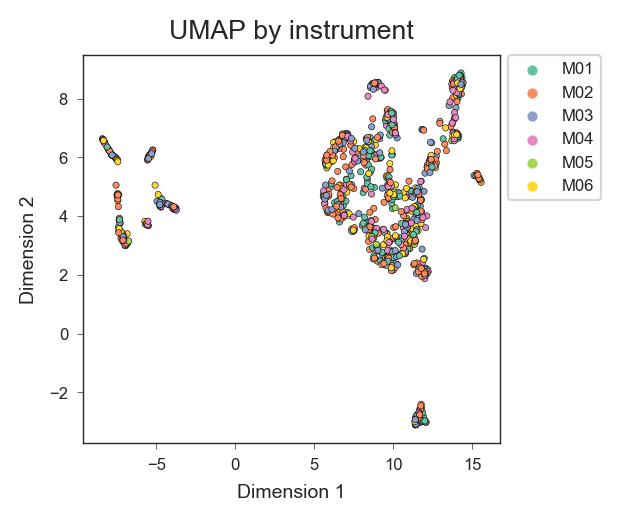

In [36]:
fig = plt.figure(figsize=(3.2, 2.7))
sns.scatterplot(x='UMAP_1',
                y='UMAP_2',
                hue='Instrument',
                data=df_umap,
                palette=instrument_colours,
                legend='full',
                edgecolor='black',
                hue_order=sorted(instrument_colours.keys()),
                s=5,
                linewidth=0.2)
plt.legend(bbox_to_anchor=(1.02, 1),
           loc=2,
           borderaxespad=0.,
           prop={'size': 6},
           markerscale=0.6)
plt.title("UMAP by instrument")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
# plt.gcf().subplots_adjust(right=0.7)
plt.tight_layout()
# plt.savefig("../../plots/landscape/umap_pca_umap_instrument.pdf", dpi=500)
plt.savefig("../../plots/final_supp_plots/SuppFig1DInstrument.pdf", dpi=500)

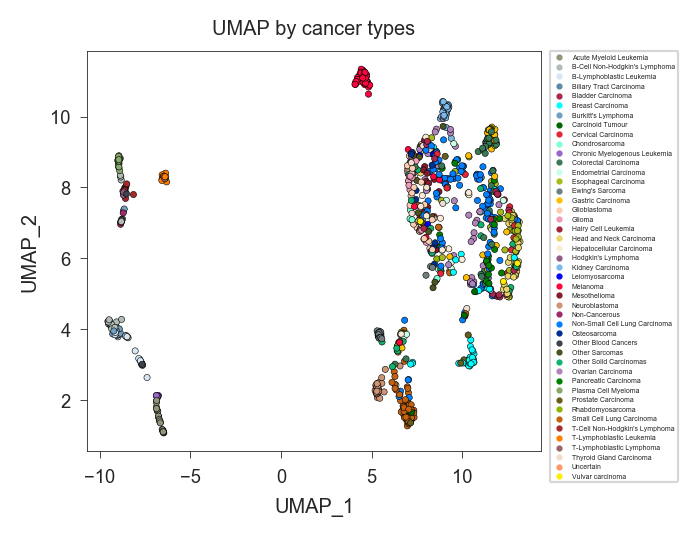

In [81]:
fig = plt.figure(figsize=(3.5, 2.7))
sns.scatterplot(x='UMAP_1',
                y='UMAP_2',
                hue='Cancer',
                hue_order=sorted(list(df_umap['Cancer'].unique())),
                data=df_umap,
                palette=cancer_colours,
                legend='full',
                edgecolor='black',
                s=5,
                linewidth=0.2)
plt.legend(bbox_to_anchor=(1.02, 1),
           loc=2,
           borderaxespad=0.,
           prop={'size': 2.5},
           markerscale=0.3)
plt.title("UMAP by cancer types")
plt.gcf().subplots_adjust(right=0.7)
plt.tight_layout()

# plt.savefig("../../plots/landscape/umap_pca_umap_all_cancer.pdf", dpi=500)

## PNS vs non PNS

In [46]:
df_umap['haem_skin_pne'] = df_umap['Tissue'].map(lambda x: x if x in [
    "Peripheral Nervous System", 'Haematopoietic and Lymphoid', 'Skin'
] else 'All other cell lines')
df_umap['pns'] = df_umap['Tissue'].map(
    lambda x: x
    if x in ["Peripheral Nervous System"] else 'All other cell lines')

([], <a list of 0 Text yticklabel objects>)

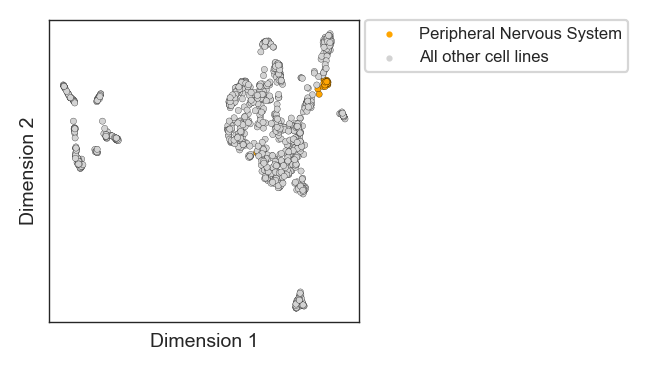

In [47]:
fig = plt.figure(figsize=(2, 2))
sns.scatterplot(x='UMAP_1',
                y='UMAP_2',
                hue='pns',
                hue_order=[
                    "Peripheral Nervous System", 'All other cell lines'
                ],
                data=df_umap,
                legend='full',
                edgecolor='black',
                palette=['orange', "lightgrey"],
                s=5,
                linewidth=0.1)
plt.legend(bbox_to_anchor=(1.02, 1),
           loc=2,
           borderaxespad=0.,
           prop={'size': 6},
           markerscale=0.3)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xticks([])
plt.yticks([])
# plt.title("UMAP by highlighted tissue types", size=8)
# plt.gcf().subplots_adjust(right=0.7)
# plt.tight_layout()

# plt.savefig("../../plots/landscape/umap_pca_umap_all_cancer.pdf", dpi=500)

## only blood

In [37]:
pca = PCA(n_components=50, random_state=seed)
reducer = umap.UMAP(random_state=seed)

pca_prot = pca.fit_transform(protein_working[~protein_working.index.isin(cell_lines_no_blood)].fillna(-2.743351))

embedding_prot = reducer.fit_transform(pca_prot)

df_umap = pd.DataFrame({
    'UMAP_1': embedding_prot[:, 0],
    'UMAP_2': embedding_prot[:, 1]
}, index=protein_working[~protein_working.index.isin(cell_lines_no_blood)].index)

df_umap['Tissue'] = df_umap.index.map(tissue_type_map)
df_umap['Cancer'] = df_umap.index.map(cancer_type_map)

In [38]:
df_umap['Cancer'] = df_umap['Cancer'].map(
    lambda x: x.replace("-cell", "-Cell").replace("leukemia", "Leukemia"))

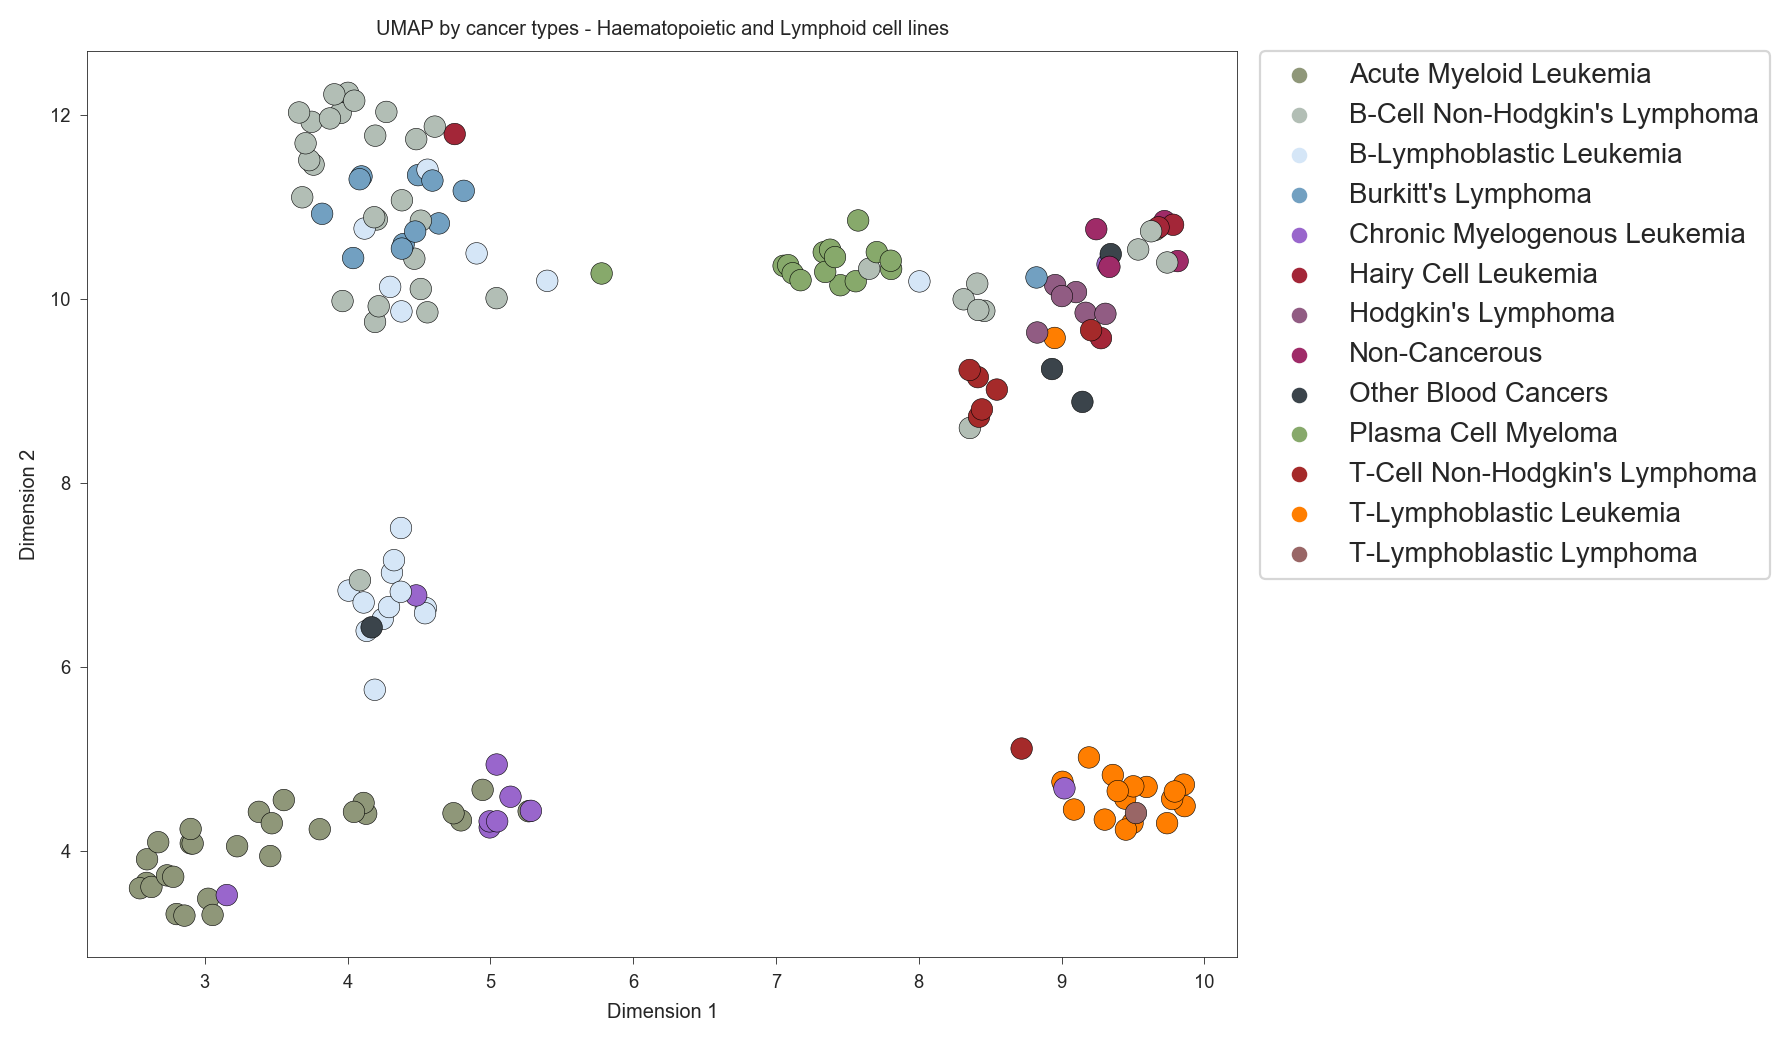

In [105]:
fig = plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='UMAP_1',
                     y='UMAP_2',
                     hue='Cancer',
                     hue_order=sorted(df_umap['Cancer'].unique()),
                     data=df_umap,
                     palette=cancer_colours,
                     legend='full',
                     edgecolor='black',
                     s=60,
                     linewidth=0.2)
# labels = [
#     ax.text(row["UMAP_1"], row["UMAP_2"], row['Cell_line'], color="k", fontsize=10)
#     for i, row in df_umap.reset_index().iterrows()
# ]
# adjust_text(labels,
#             arrowprops=dict(arrowstyle="-", color="k", alpha=0.75, lw=0.3),
#             ax=ax)

plt.legend(bbox_to_anchor=(1.02, 1),
           loc=2,
           borderaxespad=0.,
           prop={'size': 10})
plt.title("UMAP by cancer types - Haematopoietic and Lymphoid cell lines")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.gcf().subplots_adjust(right=0.7)
# plt.savefig("../../plots/landscape/umap_pca_umap_only_blood_cancer.pdf", dpi=500)
# plt.savefig("../../plots/final_supp_plots/SuppFig1E.pdf", dpi=500)
plt.savefig("../../plots/blood_by_cancer.pdf", dpi=200)

In [85]:
df_umap.to_csv("../../plots/plot_data/SuppFig1E_UMAP_onlyblood_cell_lines.csv")

In [86]:
df_umap.shape

(163, 4)

In [39]:
blood_meta_df = pd.read_excel("../../data/Hematopoietic_080321.xlsx")

In [40]:
df_blood_umap_subtype = pd.merge(df_umap, blood_meta_df, on='Cell_line')

In [41]:
df_blood_umap_subtype['lineage+cell_type'] = df_blood_umap_subtype.apply(
    lambda row: f"{row['Lineage']}+{row['Cell type']}", axis=1)

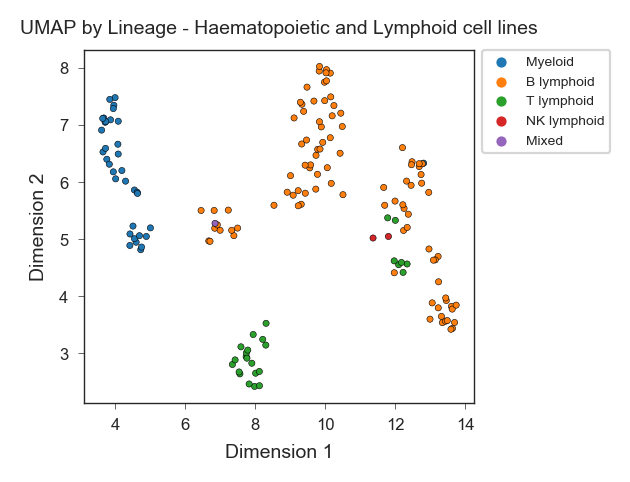

In [47]:
fig = plt.figure(figsize=(3.2, 2.5))
ax = sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='Lineage',
    data=df_blood_umap_subtype,
    palette='tab10',
    legend='full',
    edgecolor='black',
    s=5,
    linewidth=0.2)
# labels = [
#     ax.text(row["UMAP_1"], row["UMAP_2"], row['Cell_line'], color="k", fontsize=10)
#     for i, row in df_blood_umap_subtype.reset_index().iterrows()
# ]
# adjust_text(labels,
#             arrowprops=dict(arrowstyle="-", color="k", alpha=0.75, lw=0.3),
#             ax=ax)
plt.legend(bbox_to_anchor=(1.02, 1),
           loc=2,
           borderaxespad=0.,
           prop={'size': 5},
           markerscale=0.6)
plt.title("UMAP by Lineage - Haematopoietic and Lymphoid cell lines", fontdict={'size':7})
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

fig.tight_layout()
plt.savefig("../../plots/blood_by_lineage.pdf", dpi=200, show=False)
plt.savefig("../../plots/final_supp_plots/SuppFig1E.pdf", dpi=500)

In [48]:
df_blood_umap_subtype.to_csv(
    "../../plots/plot_data/Fig2B_UMAP_blood_lineage.csv", index=False)

## lung

In [44]:
pca = PCA(n_components=50, random_state=seed)
reducer = umap.UMAP(random_state=seed)

pca_prot = pca.fit_transform(protein_working[protein_working.index.isin(cell_lines_lung)].fillna(-2.743351))

embedding_prot = reducer.fit_transform(pca_prot)

df_umap = pd.DataFrame({
    'UMAP_1': embedding_prot[:, 0],
    'UMAP_2': embedding_prot[:, 1]
}, index=protein_working[protein_working.index.isin(cell_lines_lung)].index)

df_umap['Tissue'] = df_umap.index.map(tissue_type_map)
df_umap['Cancer'] = df_umap.index.map(cancer_type_map)

Text(0, 0.5, 'Dimension 2')

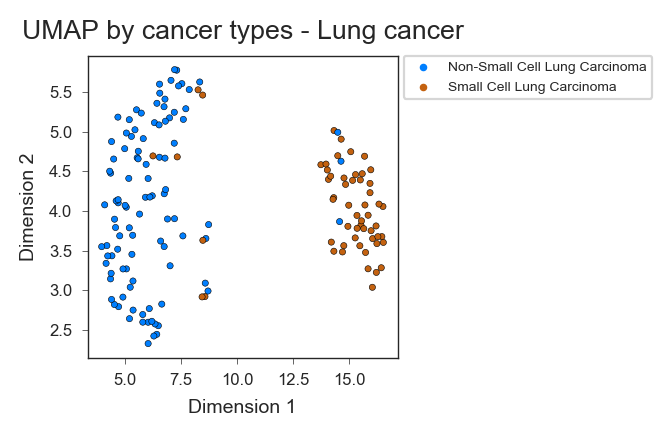

In [45]:
fig = plt.figure(figsize=(2, 2))
ax = sns.scatterplot(x='UMAP_1',
                     y='UMAP_2',
                     hue='Cancer',
                     hue_order=sorted(df_umap['Cancer'].unique()),
                     data=df_umap,
                     palette=cancer_colours,
                     legend='full',
                     edgecolor='black',
                     s=5,
                     linewidth=0.2)
# labels = [
#     ax.text(row["UMAP_1"], row["UMAP_2"], row['Cell_line'], color="k", fontsize=10)
#     for i, row in df_umap.reset_index().iterrows()
# ]
# adjust_text(labels,
#             arrowprops=dict(arrowstyle="-", color="k", alpha=0.75, lw=0.3),
#             ax=ax)

plt.legend(bbox_to_anchor=(1.02, 1),
           loc=2,
           borderaxespad=0.,
           prop={'size': 5},
           markerscale=0.4)
plt.title("UMAP by cancer types - Lung cancer")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
# plt.gcf().subplots_adjust(right=0.7)
# plt.savefig("../../plots/blood_by_cancer.pdf", dpi=200)

In [46]:
df_umap.to_csv("../../plots/plot_data/UMAP_onlylung_cell_lines.csv")

In [49]:
df_umap.query("UMAP_1 > 10 and Cancer != 'Small Cell Lung Carcinoma'")

,UMAP_1,UMAP_2,Tissue,Cancer
Cell_line,,,,
COR-L321,14.180872,6.467095,Lung,Other Solid Carcinomas
COR-L32,14.347549,6.865804,Lung,Uncertain
LK-2,13.214364,5.348720,Lung,Non-Small Cell Lung Carcinoma
NCI-H1155,12.789458,6.705957,Lung,Non-Small Cell Lung Carcinoma
NCI-H1770,12.737369,6.443926,Lung,Non-Small Cell Lung Carcinoma
NCI-H1581,11.600090,6.079634,Lung,Non-Small Cell Lung Carcinoma
NCI-H810,13.499693,5.911481,Lung,Non-Small Cell Lung Carcinoma
NCI-H720,14.255559,6.217085,Lung,Carcinoid Tumour
NCI-H520,13.288667,5.429873,Lung,Non-Small Cell Lung Carcinoma


# replicate correlation

## compute

In [25]:
def compute_corr_aux(replicate_df, group, col='Cell_line', report_mean=True):
    replicates = meta_sample[meta_sample[col]==group]['Automatic_MS_filename'].values
    replicates = [x for x in replicates if x in replicate_df.columns]
    tmp = replicate_df[replicates].corr()
    tmp = tmp.values.flatten()
    tmp = tmp[tmp!=1]
    if not report_mean:
        return tmp
    else:
        mean_corr = np.nanmean(tmp[tmp!=1])
        return mean_corr

In [26]:
def compute_corr(replicate_df, col='Cell_line', report_mean=True):
    res = Parallel(n_jobs=14)(
        delayed(compute_corr_aux)(replicate_df, group, col, report_mean)
        for group in meta_sample[col].unique())
    return np.squeeze(np.array(res))

In [27]:
def compute_corr_all_aux(replicate_df, replicates):
    tmp = replicate_df[list(replicates)].corr()
    mean_corr = np.nanmean(tmp[tmp!=1])
    return mean_corr

In [28]:
def compute_corr_all(replicate_df, n=5000):
    all_pairs = list(combinations(replicate_df.columns.values, 2))
    random_selected = random.choices(all_pairs, k=n)
    res = Parallel(n_jobs=14)(
        delayed(compute_corr_all_aux)(replicate_df, rep)
        for rep in tqdm(random_selected))
    return np.squeeze(np.array(res))

In [41]:
# replicate_raw = pd.read_csv(
#     "../../data/protein/E0022_P06_Protein_Matrix_Replicate_Raw.tsv.gz",
#     sep='\t',
#     index_col = 0).T

# replicate_median = pd.read_csv(
#     "../../data/protein/E0022_P06_Protein_Matrix_Replicate_Median.tsv.gz",
#     sep='\t',
#     index_col = 0).T

# replicate_prot = pd.read_csv(
#     "../../data/protein/e0022_diann_051021_working_matrix_replicates.txt",
#     sep='\t',
#     index_col = 0).T

replicate_prot = pd.read_csv(
    "../../data/protein/e0022_diann_051021_frozen_matrix.txt",
    sep='\t',
    index_col = 0).T

In [42]:
replicate_prot = replicate_prot[[
    x for x in replicate_prot.columns
    if x in meta_sample['Automatic_MS_filename'].unique()
]]

replicate_prot = replicate_prot[~replicate_prot.index.isin(['ProCal', 'RMISv2', 'RT-Kit-WR'])]

In [43]:
[x for x in meta_sample['Automatic_MS_filename'].unique() if x not in replicate_prot.columns]

[]

In [44]:
meta_sample[meta_sample['Automatic_MS_filename'].isin(
    replicate_prot.columns)].groupby('Cell_line').size().sort_values()

Cell_line
MOLM-13     1
SW948       3
OC-314      3
KYM-1       3
SW982       3
           ..
CL-11       8
NB5         8
OCI-M1      8
OCUM-1     10
ES1        10
Length: 949, dtype: int64

In [45]:
res_raw = {}
res_median = {}
res_prot = {}

for g in tqdm(['Cell_line','Cancer_type','Tissue_type','Batch','Instrument']):
#     res_raw[g] = compute_corr(replicate_raw, g)
#     res_median[g] = compute_corr(replicate_median, g)
    res_prot[g] = compute_corr(replicate_prot, g)

  0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
# res_raw['Random'] = compute_corr_all(replicate_raw, 10000)
# res_median['Random'] = compute_corr_all(replicate_median, 10000)
res_prot['Random'] = compute_corr_all(replicate_prot, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [47]:
replicate_corr = {'raw': res_raw, 'median': res_median, 'ruv': res_prot}

In [48]:
pickle.dump(res_prot, open("../../result_files/replicate_corr_prot.pkl", "wb"))

In [58]:
replicate_corr = pickle.load(open("../../result_files/replicate_corr.pkl", "rb"))

In [176]:
# res_raw = replicate_corr['raw']
# res_median = replicate_corr['median']
res_prot = replicate_corr['ruv']

In [33]:
replicate_corr = pickle.load(open("../../result_files/replicate_corr.pkl", "rb"))

In [53]:
# res_raw = replicate_corr['raw']
# res_median = replicate_corr['median']
res_prot = replicate_corr['ruv']

In [54]:
protdf = {'group':[], 'correlation':[]}
for key in res_prot.keys():
    protdf['correlation'].extend(res_prot[key])
    protdf['group'].extend([key.replace("_type", "")]*len(res_prot[key]))
protdf = pd.DataFrame(protdf)

In [57]:
protdf.dropna().to_csv("../../plots/plot_data/Fig1C_sample_correlation.csv",
                       index=False)

In [116]:
protdf = pd.read_csv("../../plots/plot_data/Fig1C_sample_correlation.csv")

In [118]:
protdf.groupby('group').median()

,correlation
group,
Batch,0.753733
Cancer,0.799862
Cell_line,0.916482
Instrument,0.752207
Random,0.757757
Tissue,0.786584


# highlighted drugs

In [57]:
broad = pd.read_csv("../../data/ccle/ccle_proteins_sanger_name.csv").set_index("Cell_line")

In [48]:
protein_working = pd.read_csv(
    "../../data/protein/e0022_diann_protein_matrix_270821_normalised_averaged.txt",
    sep='\t',
    index_col=0)
protein_working.index.name = 'model_id'

protein_working.index = protein_working.index.map(lambda x: x.split(';')[0])
protein_working = protein_working[[x for x in protein_working.columns if ';' in x]]
protein_working.columns = [x.split(';')[1] for x in protein_working.columns]

In [49]:
selected_drugs = ['226;GSK1070916;GDSC1', '431;Alisertib;GDSC1','2105;GSK1070916;GDSC2']
selected_proteins = ['PPIH_HUMAN']

In [50]:
drug_df = pd.read_csv("../../data/drug/drug_final_processed_eg_id.csv.gz",low_memory=False)

In [51]:
drug_df = drug_df[drug_df['drug_id'].isin(selected_drugs)]

In [52]:
drug_wide = pd.pivot(drug_df[['model_id', 'drug_id', 'ln_IC50']],
                     index='model_id',
                     columns='drug_id')
drug_wide.columns = [x[1] for x in drug_wide.columns]

In [53]:
drug_examples = pd.merge(protein_working[selected_proteins], drug_wide, on='model_id', how='outer')

drug_examples = drug_examples[~(pd.isna(drug_examples[selected_proteins]).all(axis=1))]

drug_examples['tissue'] = drug_examples.index.map(meta.set_index('SIDM').to_dict()['Tissue_type'])

In [56]:
drug_examples.to_csv("../../plots/plot_data/Fig3_drug_examples.csv")

In [73]:
drug_wide = pd.pivot(drug_df[['model_name', 'drug_id', 'ln_IC50']],
                     index='model_name',
                     columns='drug_id')
drug_wide.columns = [x[1] for x in drug_wide.columns]
drug_wide.index.name = 'Cell_line'
drug_examples_ccle = pd.merge(broad[selected_proteins],
                              drug_wide,
                              on='Cell_line',
                              how='outer')

drug_examples_ccle = drug_examples_ccle[~(
    pd.isna(drug_examples_ccle[selected_proteins]).all(axis=1))]

drug_examples_ccle['tissue'] = drug_examples_ccle.index.map(
    meta.set_index('Cell_line').to_dict()['Tissue_type'])

drug_examples_ccle = drug_examples_ccle[~pd.isna(drug_examples_ccle.index)]

In [74]:
drug_examples_ccle.to_csv("../../plots/plot_data/Fig3_drug_examples_ccle.csv")